In [1]:
import requests

In [2]:
url = 'https://query.wikidata.org/sparql'
query = """
SELECT 
  ?countryLabel ?population ?area ?medianIncome ?age
WHERE {
  ?country wdt:P463 wd:Q458.
  OPTIONAL { ?country wdt:P1082 ?population }
  OPTIONAL { ?country wdt:P2046 ?area }
  OPTIONAL { ?country wdt:P3529 ?medianIncome }
  OPTIONAL { ?country wdt:P571 ?inception. 
    BIND(year(now()) - year(?inception) AS ?age)
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""
r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

In [3]:
import pandas as pd
from collections import OrderedDict

countries = []
for item in data['results']['bindings']:
    countries.append(OrderedDict({
        'country': item['countryLabel']['value'],
        'population': item['population']['value'],
        'area': item['area']['value'] 
            if 'area' in item else None,
        'medianIncome': item['medianIncome']['value'] 
            if 'medianIncome' in item else None,
        'age': item['age']['value'] 
            if 'age' in item else None}))

df = pd.DataFrame(countries)
df.set_index('country', inplace=True)
df = df.astype({'population': float, 'area': float, 'medianIncome': float, 'age': float})
df.head()

,population,area,medianIncome,age
country,,,,
France,66628000.0,643801.00,30364.0,NaN
Germany,82979100.0,357408.74,33333.0,NaN
Bulgaria,7265115.0,110993.60,NaN,NaN
Kingdom of the Netherlands,17100715.0,NaN,NaN,204.0
Ireland,4761865.0,70273.00,25969.0,82.0


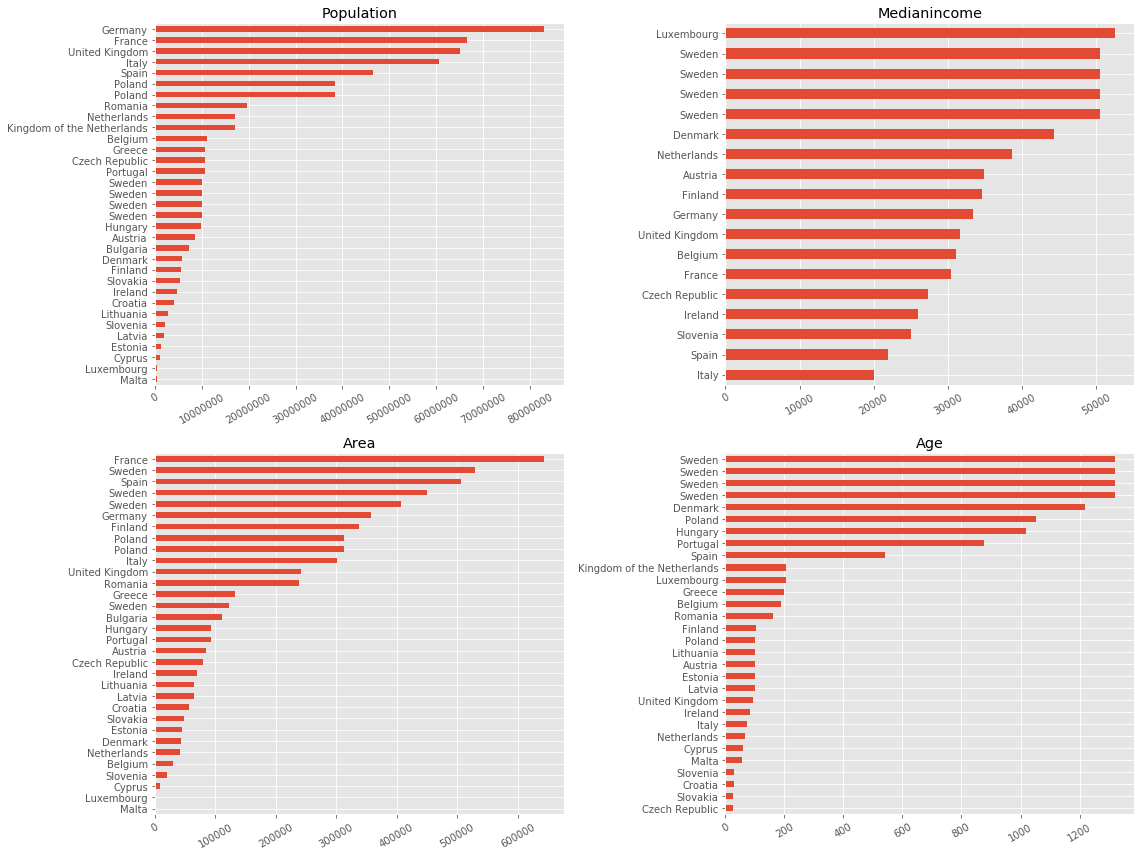

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(16, 12))
for i, label in enumerate(['population', 'medianIncome', 'area', 'age']):
    plt.subplot(2, 2, i + 1)
    df_plot = df[label].sort_values().dropna()
    df_plot.plot(kind='barh', color='C0', ax=plt.gca());
    plt.ylabel('')
    plt.xticks(rotation=30)
    plt.title(label.capitalize())
    plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

In [5]:
url = 'https://query.wikidata.org/sparql'
query="""
SELECT DISTINCT 
  ?countryLabel ?capitalLabel ?population ?capital_lon ?capital_lat
  ?mayorLabel ?birth_date ?age ?birth_place ?birth_placeLabel ?birth_place_lon ?birth_place_lat
WHERE {
  ?country wdt:P463 wd:Q458.
  ?country wdt:P36 ?capital.
  OPTIONAL { ?capital wdt:P1082 ?population. }
  
  # Get latitude longitude coordinates of capital
  ?capital p:P625/psv:P625 ?capital_node.
  ?capital_node wikibase:geoLatitude ?capital_lat.
  ?capital_node wikibase:geoLongitude ?capital_lon.

  ?capital p:P6 ?statement.
  ?statement ps:P6 ?mayor.
  FILTER NOT EXISTS { ?statement pq:P582 ?end_date }

  ?mayor wdt:P569 ?birth_date.
  BIND(year(now()) - year(?birth_date) AS ?age)
  ?mayor wdt:P19 ?birth_place.
  ?birth_place wdt:P625 ?birth_place_coordinates.
  
  # Get latitude longitude coordinates of birth place
  ?birth_place p:P625/psv:P625 ?birth_place_node.
  ?birth_place_node wikibase:geoLatitude ?birth_place_lat.
  ?birth_place_node wikibase:geoLongitude ?birth_place_lon.
  
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
"""

r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

countries = []
for item in data['results']['bindings']:
    countries.append(OrderedDict({
        label : item[label]['value'] if label in item else None
        for label in ['countryLabel', 'capitalLabel',  'capital_lon', 'capital_lat', 'population', 
                       'mayorLabel', 'birth_date', 'age', 
                       'birth_placeLabel', 'birth_place_lon', 'birth_place_lat']}))

df = pd.DataFrame(countries)
df.set_index('capitalLabel', inplace=True)
df = df.astype({'population': float, 'age': float,
                'capital_lon': float, 'capital_lat': float, 
                'birth_place_lon': float, 'birth_place_lat': float})
df.head()

,countryLabel,capital_lon,capital_lat,population,mayorLabel,birth_date,age,birth_placeLabel,birth_place_lon,birth_place_lat
capitalLabel,,,,,,,,,,
Tallinn,Estonia,24.745000,59.437222,434562.0,Taavi Aas,1966-01-10T00:00:00Z,53.0,Tallinn,24.745000,59.437222
Bucharest,Romania,26.083333,44.400000,1883425.0,Gabriela Firea,1972-07-13T00:00:00Z,47.0,Bacău,26.916667,46.583333
London,United Kingdom,-0.127500,51.507222,8787892.0,Sadiq Khan,1970-10-08T00:00:00Z,49.0,Tooting,-0.165000,51.428000
Warsaw,Poland,21.033333,52.216667,1764615.0,Rafał Trzaskowski,1972-01-17T00:00:00Z,47.0,Warsaw,21.033333,52.216667
Zagreb,Croatia,15.950000,45.800000,790017.0,Milan Bandić,1955-11-22T00:00:00Z,64.0,Grude,17.395300,43.377600


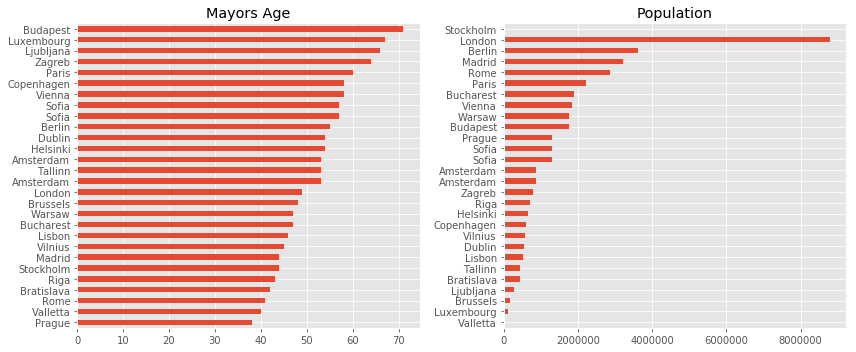

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['age'].sort_values().plot(kind='barh', color='C0', title='Mayors Age')
plt.ylabel('')
plt.subplot(1, 2, 2)
df['population'].sort_values().plot(kind='barh', color='C0', title='Population')
plt.ylabel('')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

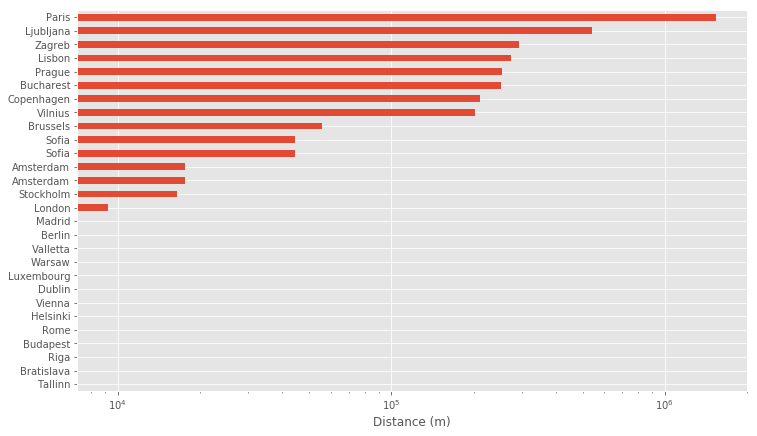

In [9]:
from geopy.distance import distance

coordinates = df[['capital_lon', 'capital_lat', 'birth_place_lon', 'birth_place_lat']]
df['distance'] = [distance((lat0, lon0), (lat1, lon1)).m 
                for lon0, lat0, lon1, lat1 in coordinates.values]

df['distance'].sort_values().plot(kind='barh', color='C0', logx=True, figsize=(12, 7))
plt.xlabel('Distance (m)')
plt.ylabel('');

In [ ]:
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?label, ?band
WHERE {
  ?band dbo:genre dbr:Punk_rock .
  ?band foaf:name ?label .
  FILTER (LANG(?label) = 'en')
}